Text Classification with a Bag-of-Words model
==============================================

This notebook demonstrates how we can train a classifier to predict a label for a text based on word counts.

The texts consist of 19th century novels in English from project Gutenberg. The selection is based on the "unsuccessful" and successful novels (low and high download counts) as used in Ashok et al (2013), [Success with style](http://aclweb.org/anthology/D13-1181).

We will consider the same classification task of successful vs unsuccessful novels.

First some preliminaries. Import the external libraries we will use.
Most importantly, we rely on Scikit-Learn to do machine learning. See http://scikit-learn.org/

In [3]:
import os
import numpy
import pandas
import matplotlib.pyplot as plt
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics
import seaborn as sns

# Tweak how tables are displayed
pandas.set_option('display.precision', 4)
pandas.set_option('display.max_colwidth', 30)
pandas.set_option('display.colheader_justify', 'left')

Load the texts and convert to a bag-of-words table
--------------------------------------------------
The bag-of-words ([BOW](http://en.wikipedia.org/wiki/Bag-of-words_model)) table will contain a count for each text and every word.

All letters are converted to lower case and we filter the words until we only have words with two or more alphanumeric characters (no punctuation).

Important parameters are:

-  ``max_features`` limits the model to consider only the top *n* most frequent words. More is often better but may be slow to compute.
- ``min_df`` and ``max_df`` restrict the words to those that occur in a certain proportion of texts.

For example, setting these to the values 0.2 and 0.8, respectively, restricts the model to words that are in at least 20%, and at most 80% of the texts. This removes rare words on the one hand, and ignores highly frequent words such as [function words](http://en.wikipedia.org/wiki/Function_word) on the other.

- ``use_idf=True`` turns on [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighting; this incorporates not only the total frequency of a word, but also the number of texts in which it appears. This means that words which are frequent in one text but not in others will get a high score, while words that are frequent in all documents receive a lower score.
- ``sublinear_tf=True`` is another variation which makes the word frequencies logarithmic.
- ``ngram_range``: selects the number of words in each feature; the default of ``(1, 1)`` selects individual words, which is most efficient. Higher numbers result in more informative features, but also requires a lot more memory. Bigrams, i.e., ``ngram_range=(2, 2)`` is a good trade-off and yields features with 2 consecutive words such as ``the man`` and ``man walks`` etc.

# transform() vs fit_transform()


fit means to fit the model to the data being provided. This is where the model "learns" from the data.

transform means to transform the data (produce model outputs) according to the fitted model.

fit_transform means to do both - Fit the model to the data, then transform the data according to the fitted model. Calling fit_transform is a convenience to avoid needing to call fit and transform sequentially on the same input.


In [4]:
# Set up a simple BOW model
# vectorizer is a variable that contains the instructions on how to read the text
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
        input='filename', lowercase=True, token_pattern=r'\b[-\w]{1,}\b',
        min_df=0.2, max_df=0.8, max_features=10000,
        use_idf=True, sublinear_tf=False, ngram_range=(2, 3)) # two args min and max value

# max features refers to analyse the top 10000 ngrams. So it will count all the ngrams
# and give you the top 10000
# Get a list of all filenames in the 'train/' folder,
# and add their text to the BOW table 'X'.
filenames = os.listdir('train/')
X = vectorizer.fit_transform(['train/' + a for a in filenames])

# X contains the read text

# .fit_transform() Learn the vocabulary dictionary and return document-term matrix.
# vectorizer.fit_transform(...) collects the vocabulary of words/ngrams (the fit part),
# and converts the texts to a table of numbers (the transform part).
# the result of that is put in the variable X, which is just a 
# table of numbers, but the vectorizer knows which columns refer to which words/ngrams

[tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

At initialization, vectorizer is empty. after you fit it on a corpus (line 10), yes, it has a list of cleaned ngrams and it knows how to convert a text to a vector of counts referring to those ngrams. When we initialise it we are just telling vectorizer how to read the text and what to store. 

the same thing happens later with the classifier. it is only trained when you use .fit()

In [5]:
print(X)

  (0, 7868)	0.008856784837524083
  (0, 1960)	0.00810655012565561
  (0, 9086)	0.007681541472414307
  (0, 2660)	0.007728465070618337
  (0, 8875)	0.006177808743427838
  (0, 9939)	0.008004628214910901
  (0, 1480)	0.007528771673423943
  (0, 6740)	0.008158443346930479
  (0, 7824)	0.005752280285738934
  (0, 8170)	0.008409366937401788
  (0, 867)	0.005975300346631213
  (0, 1461)	0.008336148874818502
  (0, 7667)	0.007281047170496041
  (0, 9631)	0.014762614933369157
  (0, 2334)	0.007266915568671429
  (0, 8671)	0.00619969818586123
  (0, 5905)	0.008158443346930479
  (0, 3749)	0.00824636662084735
  (0, 3843)	0.006749536573347323
  (0, 1013)	0.00619969818586123
  (0, 6400)	0.0074103934874451384
  (0, 5948)	0.008836319533194492
  (0, 5509)	0.007543803697719905
  (0, 1968)	0.013701299006592513
  (0, 4372)	0.007558889121859051
  :	:
  (611, 4007)	0.007800223501485249
  (611, 5742)	0.025919504957380803
  (611, 4170)	0.0024582513463978608
  (611, 1553)	0.043544197302768435
  (611, 7591)	0.0049408499457681

Inspect the vector representation
---------------------------------
To see what the vector representation looks like, we will look at how a simple [example](https://en.wikipedia.org/wiki/It_was_a_dark_and_stormy_night) is transformed to the BOW representation.

Notice that because of the parameters before, many words are ignored.

In [6]:
text = ('It was a dark and stormy night; '
        'the rain fell in torrents -- except at occasional intervals, '
        'when it was checked by a violent gust of wind which swept '
        'up the streets (for it is in London that our scene lies), '
        'rattling along the housetops, and fiercely agitating the scanty '
        'flame of the lamps that struggled against the darkness.')
with open('darkandstormy.txt', 'w', encoding='utf8') as out:
    out.write(text)
vec = vectorizer.transform(['darkandstormy.txt']) # Transform documents to document-term matrix. No training.

# we get back a large vector with a value for each possible word.
# show a table with only the non-zero items in the vector: 
feature_names = vectorizer.get_feature_names() # gets the actual words
pandas.DataFrame([(feature_names[b], (a, b), vec[a, b])
                  # from dictionary giving the word (value) , then using the (key) index
                        for a, b in zip(*vec.nonzero())], 
                       columns=['word', 'index', 'weight'])

,word,index,weight
0,when it was,"(0, 9385)",0.2647
1,when it,"(0, 9384)",0.1976
2,the streets,"(0, 7854)",0.2627
3,the rain,"(0, 7732)",0.2891
4,the darkness,"(0, 7293)",0.2265
5,that our,"(0, 7084)",0.2678
6,night the,"(0, 5219)",0.2454
7,it is in,"(0, 4319)",0.3206
8,is in,"(0, 4213)",0.2058
9,in london,"(0, 4036)",0.3235


Non-zero items will exist for a document because it stores the words from previous documents it has read. 

The Index column refers to the index of the file and the index of the word, or more generally, the row and column in the array/matrix/table

[`zip()`](https://www.geeksforgeeks.org/zip-in-python/) maps the separate values into one tuple containing all aspects of the item.

Get label for each text
----------------------
The genre of each text, whether a text is a "success" or a "failure" (based on download counts), and some other information, is specified in a separate metadata file.

Note that in the original data, a text may have multiple genres, and an arbitrary genre was picked in this case. In a more careful study the single most appropriate genre would have to be selected by hand.

In [7]:
# Print the first 5 lines to see what the metadata looks like:
for line in list(open('metadata.csv', encoding='utf8'))[:5]:
    print(line, end='')

Filename,Label,Genre,Fold,Success,Title,Author,Language,DownloadCount
103.txt,Verne_AroundTheWorldIn80Days,Adventure,1,SUCCESS,around the world in 80 days,"verne, jules, 1828-1905",en,3260
1145.txt,Hope_RupertOfHentzau,Adventure,1,SUCCESS,rupert of hentzau,"hope, anthony, 1863-1933",en,141
1947.txt,Sabatini_Scaramouche,Adventure,1,SUCCESS,scaramouche,"sabatini, rafael, 1875-1950",en,434
18857.txt,Verne_AJourneyToTheCenterOfThe,Adventure,1,SUCCESS,a journey to the center of the earth,"verne, jules, 1828-1905",en,336


the books are assigned to 5 "folds" randomly, to divide the corpus into train and test sets.

In [8]:
# Load the data; metadata.index will be the filename.
metadata = pandas.read_csv('metadata.csv', index_col='Filename', encoding='utf8')
labels = dict(zip(metadata.index, metadata['Success']))

# collect the labels we want to predict
y = numpy.array([labels[a] for a in filenames])

# Create an abbreviated label "Author_Title" for each text
authors = dict(zip(metadata.index, metadata['Author']))
titles = dict(zip(metadata.index, metadata['Title']))
abbrtitles = ['%s_%s' % (authors[a].split(',')[0].title(),
        titles[a][:15].title()) for a in filenames]

type(labels)

dict

Train a classifier
------------------

You can try different values for the parameter ``C``.
This parameter controls the level of regularization;
with higher values, the model will take more edge cases
(datapoints close to datapoints of other classes) into account.
This will give better scores on data that is similar to the training data,
but if the training data is not representative, it may result in more errors.

regularisation: ignore certain outliers. 

## Logistic Regression

[Logistic Regression Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)in its basic form, models a binary dependent variable (win/lose, pass/fail). Models the probability of a certain event existing.
The function that converts log-odds to probability is the logistic function. 

The logistic regression model itself simply models probability of output in terms of input and does not perform statistical classification (which group does a new data point belong to?) (it is not a classifier), though it can be used to make a classifier, for instance by choosing a cutoff value and classifying inputs with probability greater than the cutoff as one class, below the cutoff as the other; this is a common way to make a binary classifier.

As opposed to a linear regression model which fits the data to a straight line, a logistic regression model fits the data to a logistic regression curve, which looks like an asymptote. |S|

Multinomial regression uses a dependent variable with more than two categories. 

## lbgfs

solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

Algorithm to use in the optimization problem: 

- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

- For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

- ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

- ‘liblinear’ and ‘saga’ also handle L1 penalty

- ‘saga’ also supports ‘elasticnet’ penalty

[lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS): The algorithm's target problem is to minimize f(x) over unconstrained values (x can have any value) of the real-vector x where f is a differentiable scalar function (continuous). Trying to find the minimum value of the function. In this case, reducing the amount of error.

In [9]:
# Use the "Fold" column to split the training data into a train and test set.
# These folds were chosen in such a way that the labels are well balanced
# and all works by each other only occur in a single fold.
folds = dict(zip(metadata.index, metadata['Fold']))

# sss contains the split up sample
sss = sklearn.model_selection.PredefinedSplit([folds[a] for a in filenames])
# This returns train_index and test_index, which are arrays with indices of the datapoints
# that should be used for training and testing, respectively.


# Train a linear classifier and predict the genre of the items in the test set. 
# predict the genre?
# as before, giving instructions on how to read
clf = sklearn.linear_model.LogisticRegression(C=3, multi_class='multinomial', solver='lbfgs')

# X refers to the document-term matrix with the list of indices of cleaned ngrams
# X is a table of word counts, one document per row, one word/ngram per column.
# X[train_index] then selects only the word counts for the books that should be 
# trained on, without the books in test_index.
# y refers to the numpy array of title names of the texts in the corpus and whether they fail or succeed

# when we say sss.split(X,y) we are saying split X and y based on the instructions stored in sss
for train_index, test_index in sss.split(X, y): 
    clf.fit(X[train_index], y[train_index]) # fit => learning from the data then it predicts.
    pred = clf.predict(X[test_index]) 
    prob = clf.predict_proba(X[test_index])
print('Overall accuracy: %g %%' % sklearn.metrics.accuracy_score(y[test_index], pred))

Overall accuracy: 0.754967 %


In [10]:
clf.classes_

array(['FAILURE', 'SUCCESS'], dtype='<U7')

Evaluate the classifier
-----------------------
The breakdown shows that not all genres are predicted as well;
the f-score column is the most important.

In the [confusion matrix](http://en.wikipedia.org/wiki/Confusion_matrix)
we can see which genres were mistaken most often.
The columns hold the number of times the model predicted a genre,
while the rows show the true genres.

specifically, the diagonal from the top left to the bottom right are the counts of correct predictions.

In [11]:
print(sklearn.metrics.classification_report(y[test_index], pred))
pandas.DataFrame(sklearn.metrics.confusion_matrix(y[test_index], pred),
                 index=clf.classes_, columns=clf.classes_)

              precision    recall  f1-score   support

     FAILURE       0.73      0.80      0.77        76
     SUCCESS       0.78      0.71      0.74        75

    accuracy                           0.75       151
   macro avg       0.76      0.75      0.75       151
weighted avg       0.76      0.75      0.75       151



,FAILURE,SUCCESS
FAILURE,61,15
SUCCESS,22,53


Which words are most strongly associated with each genre?
---------------------------------------------------------
For each genre, the top 10 words most strongly linked to each genre are shown.

The words are ordered by the weight of the model for each genre combined with the average frequency of that word.

In [12]:
# Sort the weights of the classifier and take top 10 items
topfeatures = {}
avgfreq = numpy.squeeze(numpy.asarray(X.mean(axis=0)))
if len(clf.classes_) > 2:
    for n, target in enumerate(clf.classes_):
        top10 = numpy.argsort(clf.coef_[n] * avgfreq)[::-1][:10]
        topfeatures[target] = pandas.DataFrame({
                'word': [feature_names[m] for m in top10],
                'score': (clf.coef_[n] * avgfreq)[top10]},
                index=range(1, 11))
else:
    # in case of a binary classification, negative weights are for the first class,
    # positive weights for the second
    top10 = numpy.argsort(clf.coef_[0] * avgfreq)[:10]
    topfeatures[clf.classes_[0]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top10],
            'score': (clf.coef_[0] * avgfreq)[top10]},
            index=range(1, 11))
    top10 = numpy.argsort(clf.coef_[0] * avgfreq)[::-1][:10]
    topfeatures[clf.classes_[1]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top10],
            'score': (clf.coef_[0] * avgfreq)[top10]},
            index=range(1, 11))
pandas.concat(topfeatures, axis=1)

FAILURE            SUCCESS           
   word       score   word       score  
1       can t -0.0363    she had  0.0437
2        i ve -0.0251   that she  0.0257
3   the young -0.0251     you re  0.0181
4    she said -0.0206   the king  0.0175
5    the girl -0.0204   the very  0.0149
6     i shall -0.0201     i said  0.0148
7       won t -0.0190  looked at  0.0147
8      as she -0.0185   the wind  0.0127
9    the boys -0.0178    there s  0.0118
10      ain t -0.0152  among the  0.0115

Can the model predict labels for new texts?
---------------------------------------------

If you're done experimenting with the model parameters, we can load new texts that the model has never seen before, and see what it predicts.

In [13]:
# Since we now evaluate on an external held-out set,
# we can use everything as training data
clf.fit(X, y)

# Transform the new files to the format of the existing BOW table
newfiles = os.listdir('test/')
X1 = vectorizer.transform(['test/' + a for a in newfiles])
y1 = numpy.array([labels[a] for a in newfiles])
pred = clf.predict(X1)
prob = clf.predict_proba(X1)

# Evaluate
print(sklearn.metrics.classification_report(y1, pred))
pandas.DataFrame(sklearn.metrics.confusion_matrix(y1, pred),
                       index=clf.classes_,
                       columns=clf.classes_)

              precision    recall  f1-score   support

     FAILURE       0.78      0.70      0.74        80
     SUCCESS       0.72      0.80      0.76        79

    accuracy                           0.75       159
   macro avg       0.75      0.75      0.75       159
weighted avg       0.75      0.75      0.75       159



,FAILURE,SUCCESS
FAILURE,56,24
SUCCESS,16,63


Which books were the hardest to classify?
-----------------------------------------

The following table lists the Adventure books ordered by how confident the classifier is; i.e., ordered by the probability for the most likely label. A probability ranges from 0 to 1.

In the table after this the probabilities for each possible genre are given, and the probabilities of each row add up to 1.

In [14]:
result = pandas.DataFrame([
            (authors[a].title(), titles[a].title(), p, labels[a], b)
        for a, b, p in zip(newfiles, pred, prob.max(axis=1))],
        index=newfiles,
        columns=['Author', 'Title', 'prob', 'actual', 'predicted'])
result.sort_values(by='prob')

,Author,Title,prob,actual,predicted
30680.txt,"Olin, Richard",All Day Wednesday,0.5004,FAILURE,SUCCESS
24945.txt,"Mcneile, H. C. (Herman Cyr...",Mufti,0.5016,FAILURE,FAILURE
15963.txt,"Emerson, Ralph Waldo, 1803...",May-Day And Other Pieces,0.5030,SUCCESS,FAILURE
1027.txt,"Grey, Zane, 1872-1939","The Lone Star Ranger, A Ro...",0.5110,SUCCESS,FAILURE
16217.txt,"Black, William, 1841-1898",Prince Fortunatus,0.5138,FAILURE,SUCCESS
...,...,...,...,...,...
1944.txt,"Chekhov, Anton Pavlovich, ...",The Witch And Other Stories,0.9087,SUCCESS,SUCCESS
2789.txt,"Penrose, Margaret",The Motor Girls On A Tour,0.9096,FAILURE,FAILURE
1695.txt,"Chesterton, G. K. (Gilbert...","The Man Who Was Thursday, ...",0.9190,SUCCESS,SUCCESS
1290.txt,"Flaubert, Gustave, 1821-1880",Salammbo,0.9554,SUCCESS,SUCCESS


In [15]:
# Show probabilities of all labels for each novel (in case of 2 labels, this doesn't give extra information)
x = pandas.DataFrame(prob, index=newfiles, columns=clf.classes_)
x.loc[x.max(axis=1).sort_values().index, :]  # order from lowest to highest probability

,FAILURE,SUCCESS
30680.txt,0.4996,0.5004
24945.txt,0.5016,0.4984
15963.txt,0.5030,0.4970
1027.txt,0.5110,0.4890
16217.txt,0.4862,0.5138
...,...,...
1944.txt,0.0913,0.9087
2789.txt,0.9096,0.0904
1695.txt,0.0810,0.9190
1290.txt,0.0446,0.9554


In [16]:
genres = dict(zip(metadata.index, metadata['Genre']))
result = pandas.DataFrame([
            (authors[a].title(), titles[a].title(), genres[a], p, labels[a], b)
        for a, b, p in zip(newfiles, pred, prob.max(axis=1))],
        index=newfiles,
        columns=['Author', 'Title', 'Genre', 'prob', 'actual', 'predicted'])
result.sort_values(by='prob')

# filter this dataframe to see one genre and see difficulty. 

# include plots in abstract. You can also talk about specific books. Don't include future research. ON your own research

,Author,Title,Genre,prob,actual,predicted
30680.txt,"Olin, Richard",All Day Wednesday,Sci-Fi,0.5004,FAILURE,SUCCESS
24945.txt,"Mcneile, H. C. (Herman Cyr...",Mufti,Mystery,0.5016,FAILURE,FAILURE
15963.txt,"Emerson, Ralph Waldo, 1803...",May-Day And Other Pieces,Poetry,0.5030,SUCCESS,FAILURE
1027.txt,"Grey, Zane, 1872-1939","The Lone Star Ranger, A Ro...",Fiction,0.5110,SUCCESS,FAILURE
16217.txt,"Black, William, 1841-1898",Prince Fortunatus,Fiction,0.5138,FAILURE,SUCCESS
...,...,...,...,...,...,...
1944.txt,"Chekhov, Anton Pavlovich, ...",The Witch And Other Stories,Short,0.9087,SUCCESS,SUCCESS
2789.txt,"Penrose, Margaret",The Motor Girls On A Tour,Mystery,0.9096,FAILURE,FAILURE
1695.txt,"Chesterton, G. K. (Gilbert...","The Man Who Was Thursday, ...",Mystery,0.9190,SUCCESS,SUCCESS
1290.txt,"Flaubert, Gustave, 1821-1880",Salammbo,Love,0.9554,SUCCESS,SUCCESS


In [17]:
result.loc[result["Genre"] == "Sci-Fi"]

,Author,Title,Genre,prob,actual,predicted
30680.txt,"Olin, Richard",All Day Wednesday,Sci-Fi,0.5004,FAILURE,SUCCESS
28156.txt,"Sharkey, Jack, 1931-",Minor Detail,Sci-Fi,0.6476,FAILURE,SUCCESS
29458.txt,"Sheckley, Robert, 1928-2005",Cost Of Living,Sci-Fi,0.6593,SUCCESS,FAILURE
10391.txt,"Waterloo, Stanley, 1846-1913",The Wolf'S Long Howl,Sci-Fi,0.5229,FAILURE,SUCCESS
18109.txt,"Piper, H. Beam, 1904-1964",Graveyard Of Dreams,Sci-Fi,0.5325,SUCCESS,FAILURE
19029.txt,"Norton, Andre, 1912-2005",The Gifts Of Asti,Sci-Fi,0.5293,SUCCESS,SUCCESS
30386.txt,"Marlowe, Stephen, 1928-2008",The One And The Many,Sci-Fi,0.6412,FAILURE,FAILURE
29601.txt,"Robles, Edward G.",See?,Sci-Fi,0.5445,FAILURE,SUCCESS
29548.txt,"Sheckley, Robert, 1928-2005",Warrior Race,Sci-Fi,0.6505,SUCCESS,FAILURE
18342.txt,"Piper, H. Beam, 1904-1964",The Answer,Sci-Fi,0.5617,SUCCESS,SUCCESS


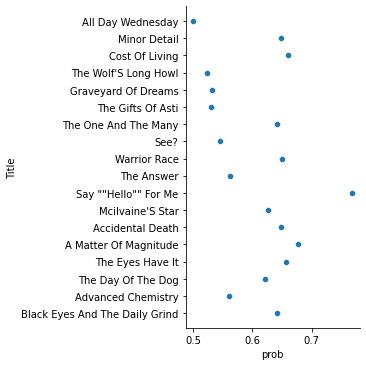

In [18]:
sci = result.loc[result["Genre"] == "Sci-Fi"]
sns.relplot(data = sci, x="prob", y="Title");

In [27]:
result.loc[result["Genre"] == "Historical"]

,Author,Title,Genre,prob,actual,predicted
12959.txt,"Marryat, Frederick, 1792-1848",Newton Forster,Historical,0.6383,FAILURE,SUCCESS
30723.txt,"Turgenev, Ivan Sergeevich,...",Fathers And Children,Historical,0.7441,SUCCESS,SUCCESS
14656.txt,"Barr, Robert, 1850-1912",The Sword Maker,Historical,0.6521,FAILURE,FAILURE
7037.txt,"Henty, G. A. (George Alfre...",Beric The Briton : A Story...,Historical,0.5420,SUCCESS,SUCCESS
1965.txt,"Sabatini, Rafael, 1875-1950",Captain Blood,Historical,0.8253,SUCCESS,SUCCESS
11228.txt,"Chesnutt, Charles W. (Char...",The Marrow Of Tradition,Historical,0.6079,SUCCESS,SUCCESS
30344.txt,"Defoe, Daniel, 1661?-1731",The Fortunate Mistress (Pa...,Historical,0.8792,SUCCESS,SUCCESS
10094.txt,"Stevenson, Burton Egbert, ...",A Soldier Of Virginia A Ta...,Historical,0.5958,FAILURE,FAILURE
11413.txt,"Doyle, Arthur Conan, Sir, ...",The Refugees A Tale Of Two...,Historical,0.5796,SUCCESS,SUCCESS
3340.txt,"Sue, Eugène, 1804-1857",The Wandering Jew: Volume 02,Historical,0.7898,FAILURE,SUCCESS


/Users/rik/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


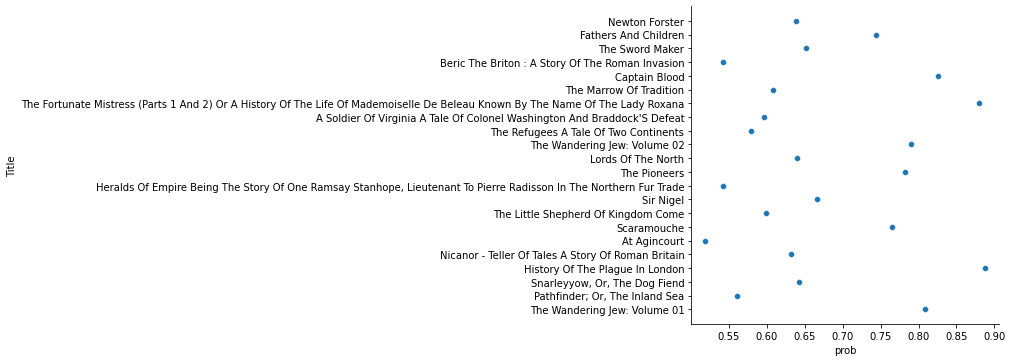

In [20]:
his = result.loc[result["Genre"] == "Historical"]
sns.relplot(data = his, x="prob", y="Title");

Which words are most strongly associated with each label?
---------------------------------------------------------
For each label, the top 10 words most strongly linked to each label are shown.

The words are ordered by the weight of the model for each label combined with the average frequency of that word.

In [26]:
# Sort the weights of the classifier and take top 10 items
topfeatures = {}
avgfreq = numpy.squeeze(numpy.asarray(X.mean(axis=0)))
if len(clf.classes_) > 2:
    for n, target in enumerate(clf.classes_):
        top10 = numpy.argsort(clf.coef_[n] * avgfreq)[::-1][:10]
        topfeatures[target] = pandas.DataFrame({
                'word': [feature_names[m] for m in top10],
                'score': (clf.coef_[n] * avgfreq)[top10]},
                index=range(1, 11))
else:
    # in case of a binary classification, negative weights are for the first class,
    # positive weights for the second
    top10 = numpy.argsort(clf.coef_[0] * avgfreq)[:10]
    topfeatures[clf.classes_[0]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top10],
            'score': (clf.coef_[0] * avgfreq)[top10]},
            index=range(1, 11))
    top10 = numpy.argsort(clf.coef_[0] * avgfreq)[::-1][:10]
    topfeatures[clf.classes_[1]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top10],
            'score': (clf.coef_[0] * avgfreq)[top10]},
            index=range(1, 11))
pandas.concat(topfeatures, axis=1)

FAILURE             SUCCESS           
   word        score   word       score  
1     she said -0.0413    she had  0.0515
2        can t -0.0380   that she  0.0232
3     the girl -0.0275     you re  0.0204
4    the young -0.0239  looked at  0.0181
5     the boys -0.0215     i said  0.0168
6       as she -0.0208  the house  0.0153
7        won t -0.0203   the wind  0.0147
8   the doctor -0.0146    there s  0.0142
9          i m -0.0133    kind of  0.0136
10    her eyes -0.0130    so that  0.0135